In [1]:
import json
import fasttext
import fasttext.util
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Keyword PCA

This notebook analyses the embeddings created for keywords. Its objective is to observe if keywords for a certain concept are close to each other in the space where the base is the Principal Components.

## Loading the data
Loading Keyword dataframe and the dataframe that contains the keywords associated with the CCS concepts.

In [2]:
kwp_df = pd.read_csv("Data/keywords_preprocessed.csv")
kwp_df.head()

,Keywords,Occurences
0,archiving,6
1,collaboration,99
2,copyright,7
3,journal policy,2
4,preprints,2


In [3]:
with open('Data/count_ccs_kw.json', 'r') as fp:
    count_ccs_kw = json.load(fp)

## Load the FastText Model

To understand the library, you can look at the documentation available [here](https://fasttext.cc/docs/en/python-module.html#train_unsupervised-parameters).

In [4]:
ft_model = fasttext.load_model('Models/cc.en.300.bin')

## Shaping Data for Experiment

### Selecting Keywords assigned to only one ccs concept

In [5]:
kw_ccs_dict = {}

for ccs_concept, kw_occ in count_ccs_kw.items():
    for kw in kw_occ.keys():
        if(kw in kw_ccs_dict.keys()):
            kw_ccs_dict[kw].append(ccs_concept)
        else:
            kw_ccs_dict[kw] = [ccs_concept]

kw_ccs_df = pd.DataFrame({"keyword_names": kw_ccs_dict.keys(), "ccs_concepts": kw_ccs_dict.values()})
kw_ccs_df.tail()

,keyword_names,ccs_concepts
69549,invertible bloom lookup tables,[Theory of computation~Bloom Filters and Hashi...
69550,low-density parity check codes,[Theory of computation~Bloom Filters and Hashi...
69551,shingled write disk,[Software and its engineering~File systems man...
69552,emotion label,[Information Technology and Systems~Models and...
69553,cold-start system,[Information Technology and Systems~Models and...


In [6]:
kw_w_single_ccs_concept = kw_ccs_df[kw_ccs_df.ccs_concepts.apply(len) == 1]
kw_w_single_ccs_concept.ccs_concepts = kw_w_single_ccs_concept.ccs_concepts.apply(lambda x: x[0])
kw_w_single_ccs_concept.tail()

/tmp/ipykernel_285/1879614038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kw_w_single_ccs_concept.ccs_concepts = kw_w_single_ccs_concept.ccs_concepts.apply(lambda x: x[0])


,keyword_names,ccs_concepts
69541,tie-breaking strategy,Mathematics of computing~Numerical analysis
69542,unit in the first place,Mathematics of computing~Numerical analysis
69543,unit roundoff,Mathematics of computing~Numerical analysis
69547,outlier,Mathematics of computing~Statistical software
69551,shingled write disk,Software and its engineering~File systems mana...


In [7]:
kw_w_single_ccs_concept.describe()

,keyword_names,ccs_concepts
count,9651,9651
unique,9651,684
top,corr,CCS->Social and professional topics->Professio...
freq,1,360


### Creating Embeddings for Keywords

In [8]:
kw_w_single_ccs_concept["embedding"] = kw_w_single_ccs_concept.keyword_names.apply(ft_model.get_sentence_vector)
kw_w_single_ccs_concept.tail()

/tmp/ipykernel_285/2550201156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kw_w_single_ccs_concept["embedding"] = kw_w_single_ccs_concept.keyword_names.apply(ft_model.get_sentence_vector)


,keyword_names,ccs_concepts,embedding
69541,tie-breaking strategy,Mathematics of computing~Numerical analysis,"[-0.0427112, -0.015729064, 0.044148225, 0.0533..."
69542,unit in the first place,Mathematics of computing~Numerical analysis,"[-0.019808296, 0.019794848, 0.018658817, 0.079..."
69543,unit roundoff,Mathematics of computing~Numerical analysis,"[-0.004891781, 0.004699469, 0.02299121, 0.0371..."
69547,outlier,Mathematics of computing~Statistical software,"[-0.028650522, 0.019630466, -0.056992363, 0.04..."
69551,shingled write disk,Software and its engineering~File systems mana...,"[-0.034040693, 0.03296573, 0.0014987992, 0.068..."


## Computing the PCA

In [34]:
pca = PCA(n_components=30)
principalComponents = pca.fit_transform(np.array(list(kw_w_single_ccs_concept.embedding)))


principalDf = pd.DataFrame(data = principalComponents[:,:3],#we only take the first 3 components
             columns = ['principal component 1', 'principal component 2', 'principal component 3'])

principalDf

,principal component 1,principal component 2,principal component 3
0,0.004869,0.245672,0.099944
1,-0.142310,-0.142040,0.108412
2,0.001458,0.004222,0.259575
3,0.057974,-0.101429,0.170426
4,0.010752,0.002819,0.137190
...,...,...,...
9646,-0.058714,-0.041224,-0.106165
9647,0.068966,-0.122600,-0.005867
9648,-0.045522,0.166914,0.021729
9649,0.021730,0.116340,-0.236074


In [35]:
compute_transformation = False
if(compute_transformation):
    principalDf = principalDf.apply(lambda x: np.tan(x*np.pi/2))

In [29]:
targets = pd.DataFrame(data = list(kw_w_single_ccs_concept.ccs_concepts),
              columns = ['ccs_concepts'])

finalDf = pd.concat([principalDf, targets], axis = 1)
finalDf

,principal component 1,principal component 2,principal component 3,ccs_concepts
0,0.007687,0.406263,0.158361,CCS->Information systems->World Wide Web->Web ...
1,-0.227336,-0.226904,0.171982,CCS->Information systems->World Wide Web->Web ...
2,0.002343,0.006608,0.432060,CCS->Information systems->World Wide Web->Web ...
3,0.091371,-0.160663,0.274371,CCS->Information systems->World Wide Web->Web ...
4,0.016878,0.004331,0.218929,CCS->Information systems->World Wide Web->Web ...
...,...,...,...,...
9646,-0.092494,-0.065061,-0.168346,Mathematics of computing~Numerical analysis
9647,0.108719,-0.195060,-0.009172,Mathematics of computing~Numerical analysis
9648,-0.071605,0.268264,0.034217,Mathematics of computing~Numerical analysis
9649,0.034115,0.184997,-0.389203,Mathematics of computing~Statistical software


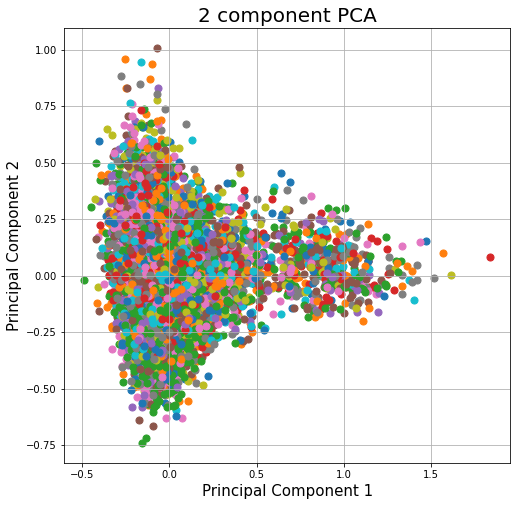

In [30]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = kw_w_single_ccs_concept.ccs_concepts.unique()
# colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = target == finalDf['ccs_concepts']
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
            #    , c = color
               , s = 50)
# ax.legend(targets)
ax.grid()

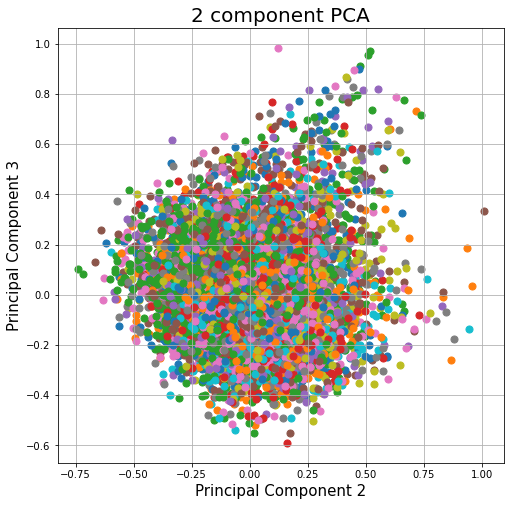

In [31]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = kw_w_single_ccs_concept.ccs_concepts.unique()
# colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = target == finalDf['ccs_concepts']
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
            #    , c = color
               , s = 50)
# ax.legend(targets)
ax.grid()

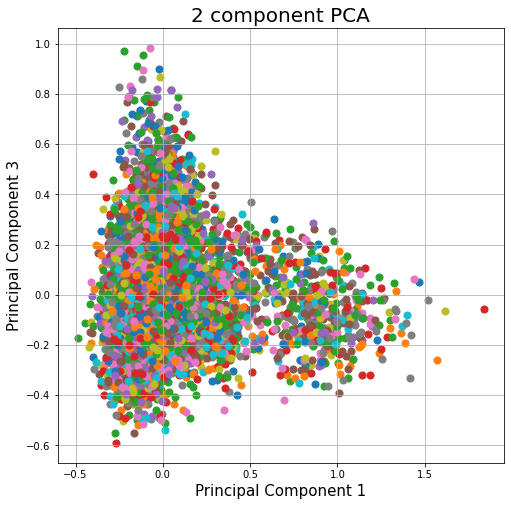

In [32]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = kw_w_single_ccs_concept.ccs_concepts.unique()
# colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = target == finalDf['ccs_concepts']
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 3']
            #    , c = color
               , s = 50)
# ax.legend(targets)
ax.grid()

#### Analyzing a smaller sample

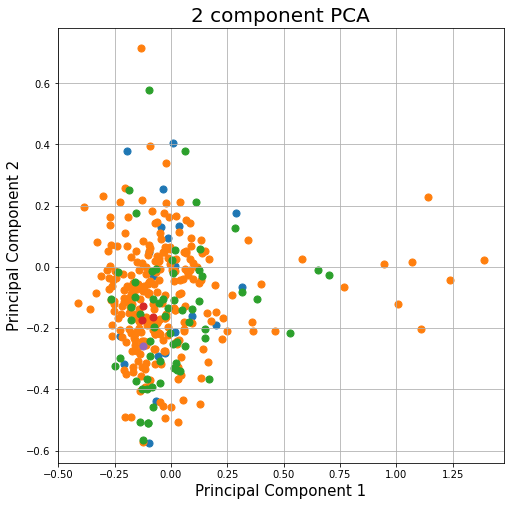

In [33]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = kw_w_single_ccs_concept.ccs_concepts.unique()[:5]
# colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = target == finalDf['ccs_concepts']
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
            #    , c = color
               , s = 50)
# ax.legend(targets)
ax.grid()

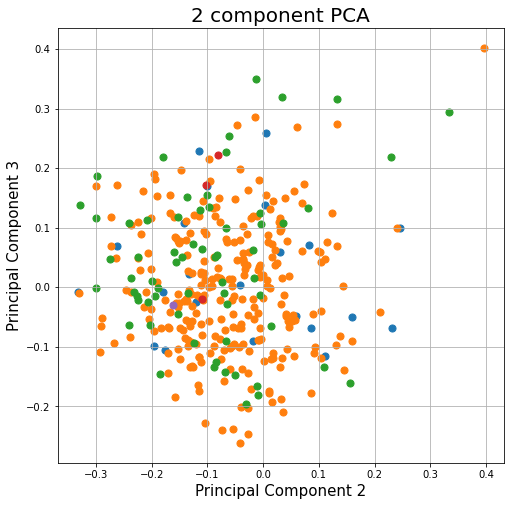

In [76]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = kw_w_single_ccs_concept.ccs_concepts.unique()[:5]
# colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = target == finalDf['ccs_concepts']
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
            #    , c = color
               , s = 50)
# ax.legend(targets)
ax.grid()

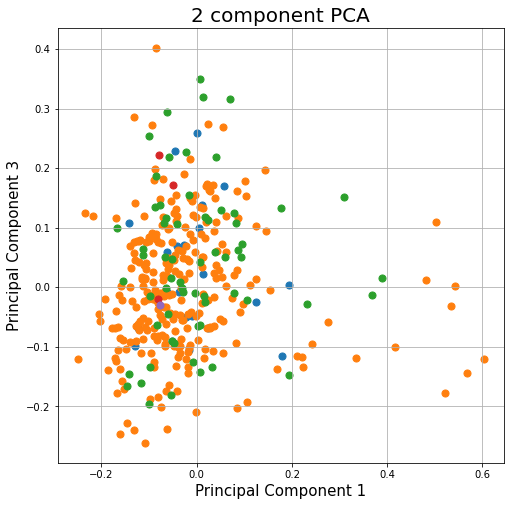

In [77]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = kw_w_single_ccs_concept.ccs_concepts.unique()[:5]
# colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = target == finalDf['ccs_concepts']
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 3']
            #    , c = color
               , s = 50)
# ax.legend(targets)
ax.grid()

### PCA Explained

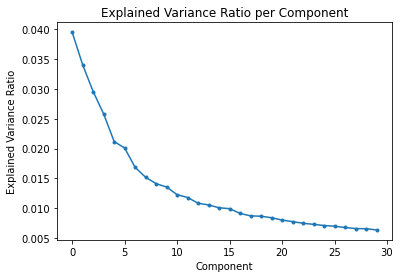

In [71]:
plt.plot(pca.explained_variance_ratio_, ".-")
plt.title("Explained Variance Ratio per Component")
plt.xlabel("Component")
plt.ylabel("Explained Variance Ratio")
plt.show()

In [75]:
print("Percentage of explained variance of the first three components is equal to : {}".format(np.sum(pca.explained_variance_ratio_[:3])))

Percentage of explained variance of the first three components is qual to : 0.10315583646297455


#### Pas très conclusif, les embeddings de fastext ne permettent donc pas de distinguer entre les concepts CCS ??
Essayer avec les distribs.